# 1. VHM Dataset

In [ ]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price'].values.reshape(-1, 1)

In [ ]:
df1

array([[68421.],
       [70075.],
       [68421.],
       ...,
       [39450.],
       [39000.],
       [38850.]])

In [ ]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(df1)

In [ ]:
df1

array([[0.5961768 ],
       [0.62907782],
       [0.5961768 ],
       ...,
       [0.01989179],
       [0.01094048],
       [0.00795672]])

## Ratio 9:1

In [ ]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [ ]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
17/17 [==============================] - 1s 13ms/step - loss: 0.0694 - val_loss: 0.0033
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0072 - val_loss: 0.0028
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 6.6629e-04
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 9.1264e-04
Epoch 8/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 6.5599e-04
Epoch 9/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 7.1182e-04
Epoch 10/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss:

In [ ]:
# 9. Dự báo dữ liệu test
y_pred = model.predict(X_test)

In [ ]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1076.0081799254883
Testing MAPE: 2.1783451599870784
Testing MAE: 891.5733366935484


In [ ]:
# !pip install "tensorflow==2.8.0"
# Chạy khi bị lỗi dòng dự báo

In [ ]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


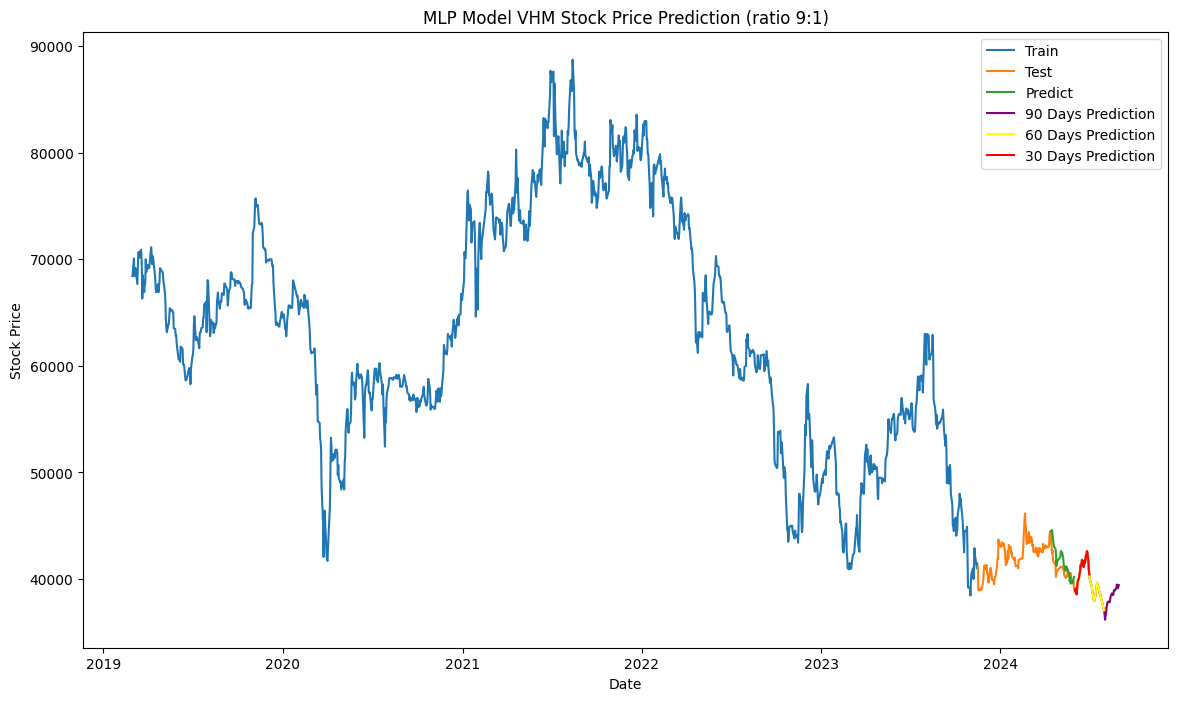

In [ ]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model VHM Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 8:2

In [ ]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [ ]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
15/15 [==============================] - 1s 15ms/step - loss: 0.0879 - val_loss: 0.0092
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0133 - val_loss: 0.0060
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0077 - val_loss: 0.0090
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0052
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0052
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 9/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 10/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 11

In [ ]:
# 9. Dự báo dữ liệu test
y_pred = model.predict(X_test)

In [ ]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 2893.7658280352903
Testing MAPE: 4.38566245425736
Testing MAE: 1801.3776523919753


In [ ]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


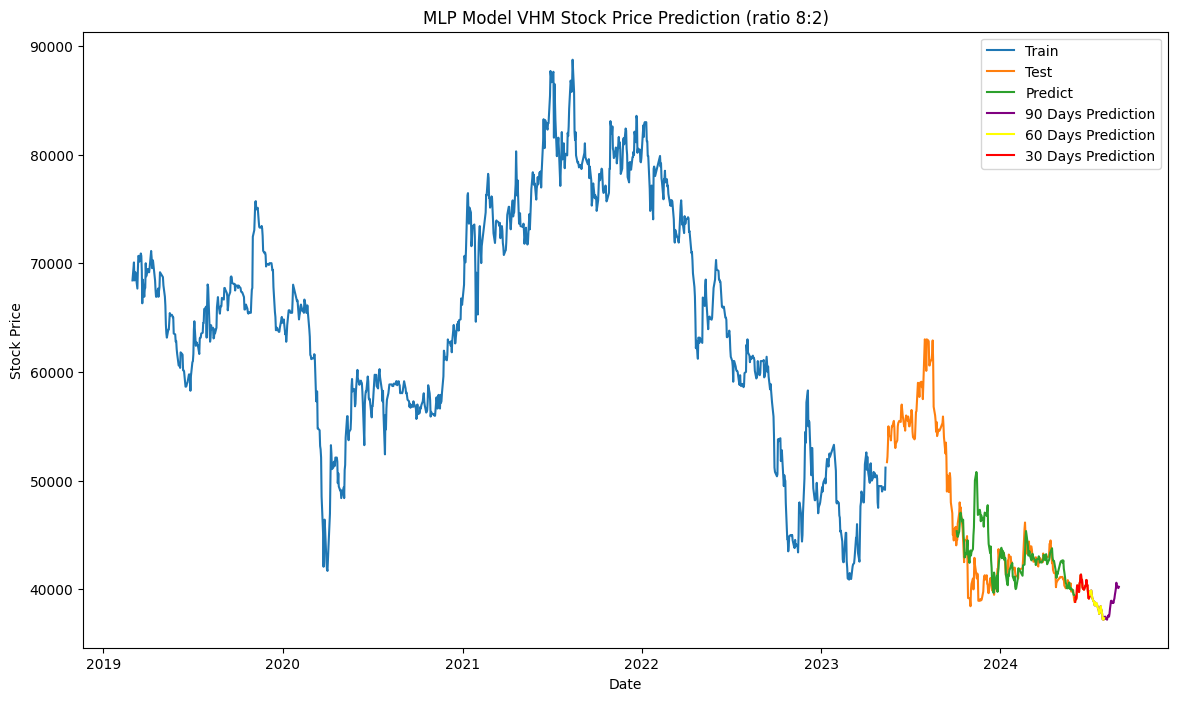

In [ ]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model VHM Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 7:3

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [ ]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
13/13 [==============================] - 1s 21ms/step - loss: 0.0497 - val_loss: 0.0064
Epoch 2/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0050
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 7/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 8/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 9/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 10/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 

In [ ]:
# 9. Dự báo dữ liệu test
y_pred = model.predict(X_test)

In [ ]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 2183.692668229563
Testing MAPE: 3.48542565232015
Testing MAE: 1571.346789675768


In [ ]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

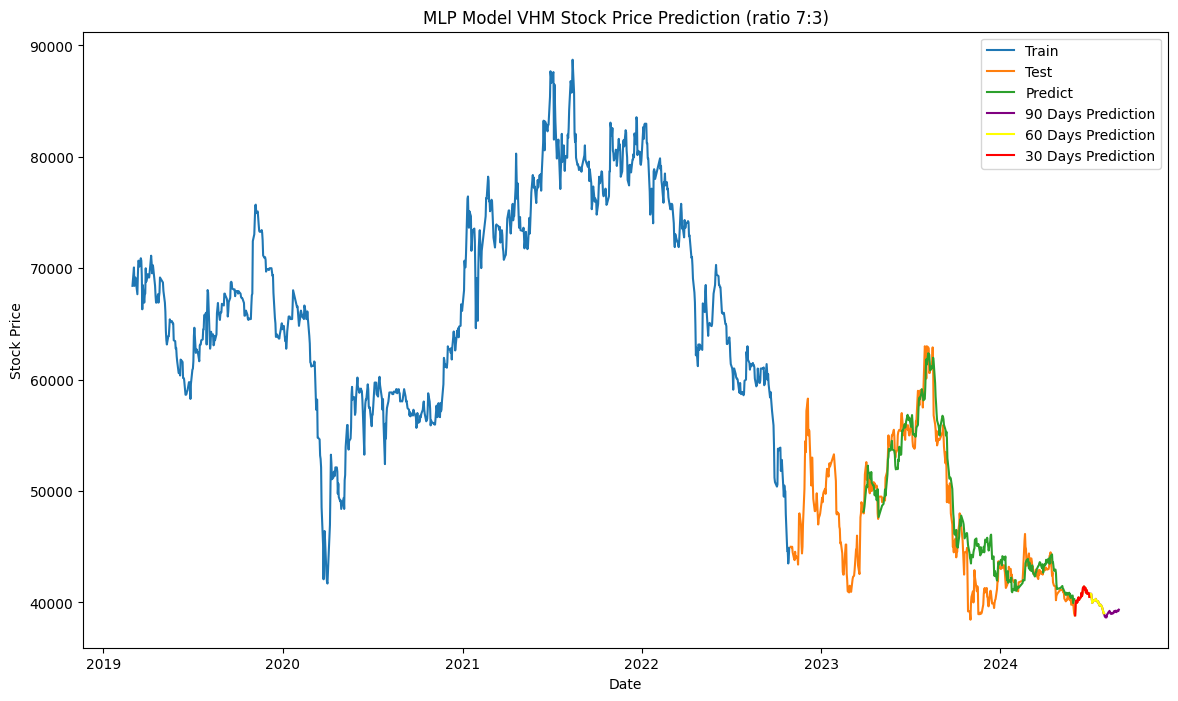

In [ ]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model VHM Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

# 2. NVL Dataset

In [ ]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/2 - NVL Historical Data.csv')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price'].values.reshape(-1, 1)

In [ ]:
df1

array([[32933.],
       [33100.],
       [32711.],
       ...,
       [14150.],
       [14150.],
       [14450.]])

In [ ]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(df1)

## Ratio 9:1

In [ ]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [ ]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
17/17 [==============================] - 1s 17ms/step - loss: 0.0695 - val_loss: 9.8449e-04
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0020
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 4/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 6.0936e-04
Epoch 6/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 4.1554e-04
Epoch 7/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 2.6339e-04
Epoch 8/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 4.5300e-04
Epoch 9/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 2.3897e-04
Epoch 10/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0014 - v

In [ ]:
# 9. Dự báo dữ liệu test
y_pred = model.predict(X_test)

In [ ]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 974.9161848236707
Testing MAPE: 5.3645872119753095
Testing MAE: 786.2326423891129


In [ ]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


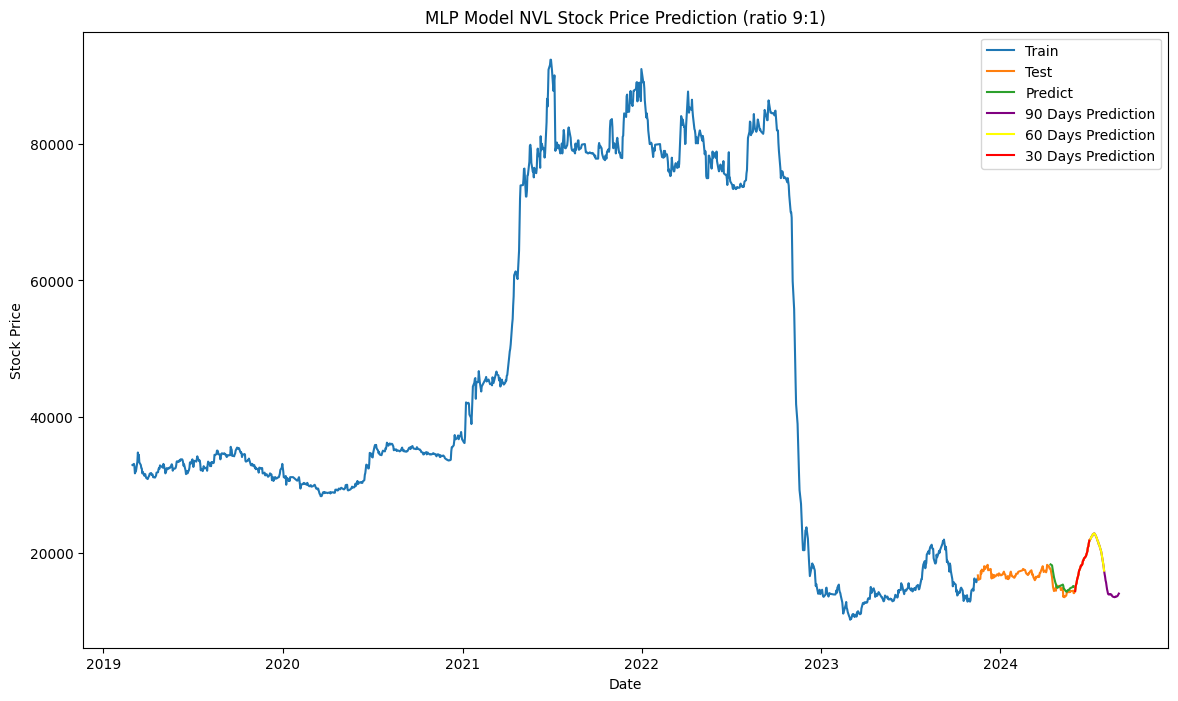

In [ ]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model NVL Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 8:2

In [ ]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [ ]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 0.0762 - val_loss: 3.4444e-04
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0109 - val_loss: 6.2697e-04
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 7.2966e-04
Epoch 4/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0034 - val_loss: 5.4237e-04
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 4.3502e-04
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 4.1802e-04
Epoch 7/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 3.1766e-04
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 2.7400e-04
Epoch 9/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 2.9616e-04
Epoch 10/100
15/15 [==============================] - 0s 6ms/step - loss

In [ ]:
# 9. Dự báo dữ liệu test
y_pred = model.predict(X_test)

In [ ]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 840.0522591507614
Testing MAPE: 4.057494488474423
Testing MAE: 652.0717592592592


In [ ]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

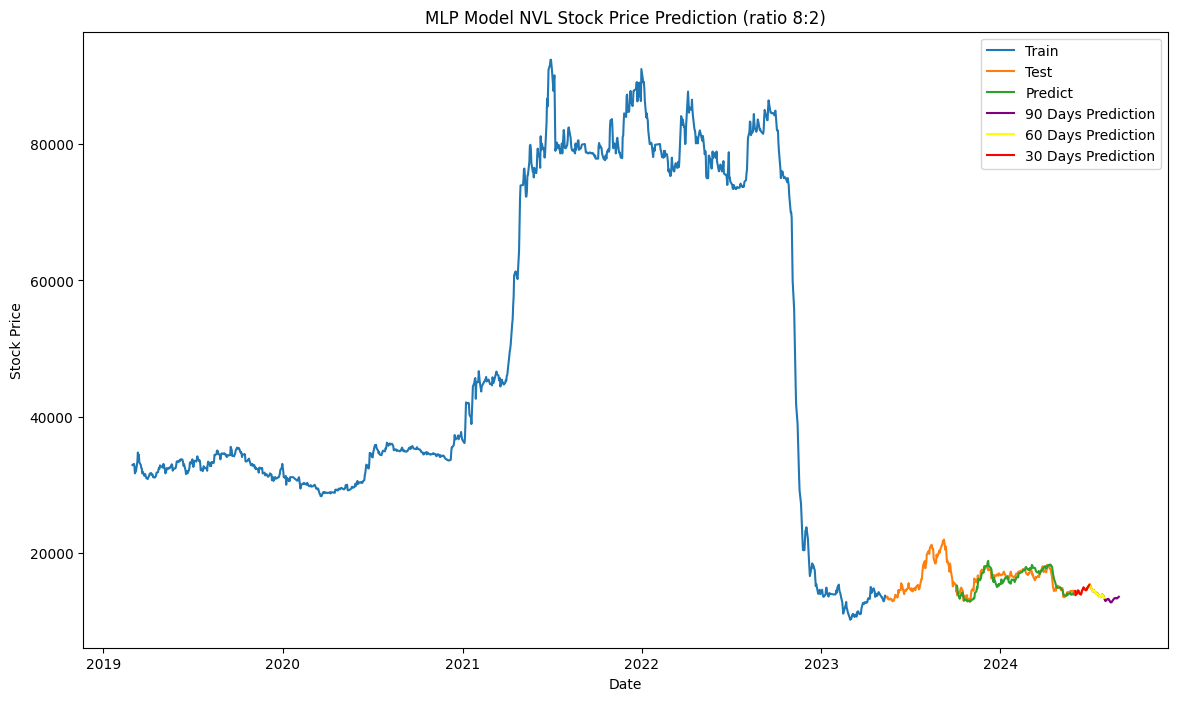

In [ ]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model NVL Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 7:3

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [ ]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
13/13 [==============================] - 1s 14ms/step - loss: 0.0968 - val_loss: 6.3849e-04
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 8.4851e-04
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0062 - val_loss: 0.0011
Epoch 4/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0011
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 6/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 7/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 8/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 8.4203e-04
Epoch 9/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 8.5048e-04
Epoch 10/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss:

In [ ]:
# 9. Dự báo dữ liệu test
y_pred = model.predict(X_test)

In [ ]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 1510.8301969929296
Testing MAPE: 8.333132781070889
Testing MAE: 1262.1569999200085


In [ ]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

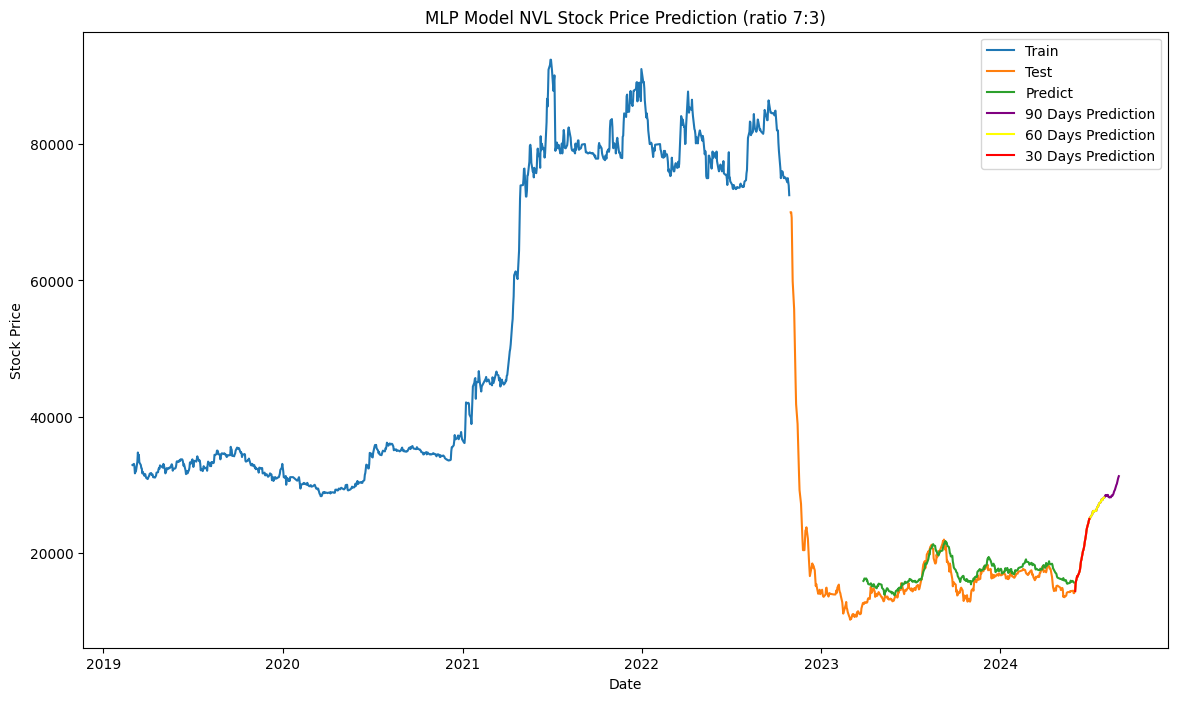

In [ ]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model NVL Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

# 3. NLG Dataset

In [ ]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price'].values.reshape(-1, 1)

In [ ]:
df1

array([[18706.8],
       [19127.2],
       [18917. ],
       ...,
       [44400. ],
       [43700. ],
       [44000. ]])

In [ ]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(df1)

## Ratio 9:1

In [ ]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [ ]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
17/17 [==============================] - 1s 15ms/step - loss: 0.0397 - val_loss: 0.0025
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0030
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0052
Epoch 5/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 7/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 8/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 9/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 10/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 11

In [ ]:
# 9. Dự báo dữ liệu test
y_pred = model.predict(X_test)

In [ ]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 1506.0566368537916
Testing MAPE: 3.094814300447588
Testing MAE: 1247.4674899193549


In [ ]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

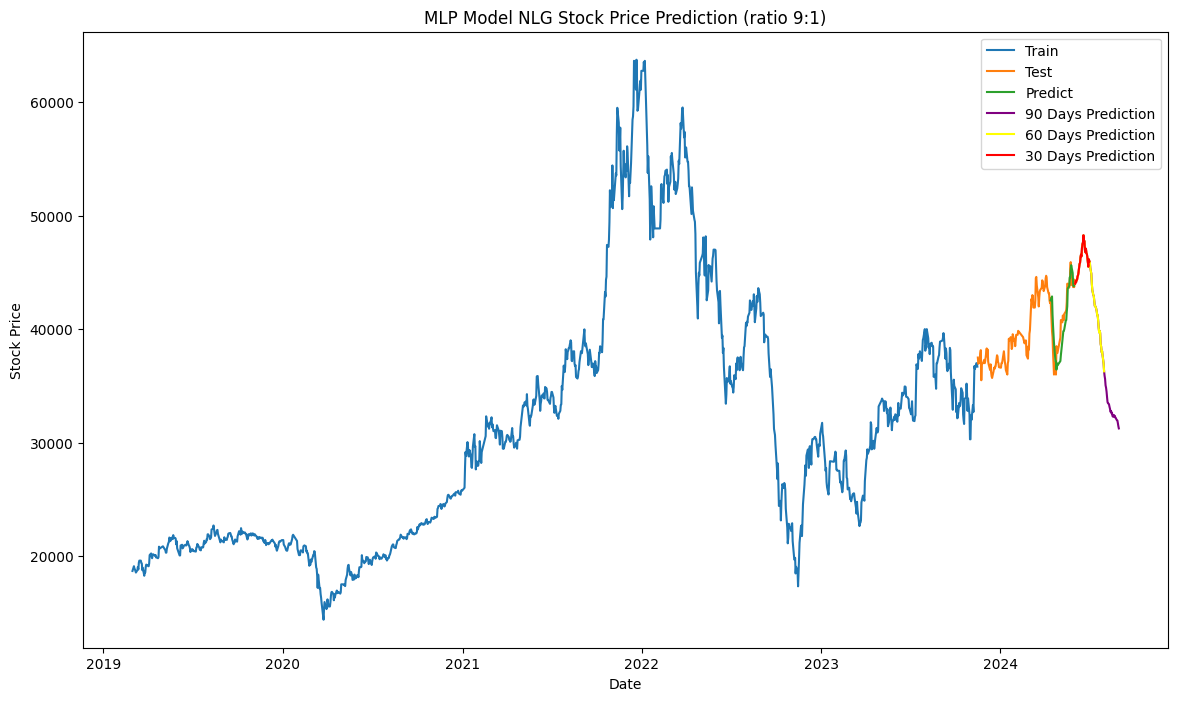

In [ ]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model NLG Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

## Ratio 8:2

In [ ]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [ ]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
15/15 [==============================] - 1s 13ms/step - loss: 0.0209 - val_loss: 0.0049
Epoch 2/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 3/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 4/100
15/15 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 6/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 7/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 8/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 9/100
15/15 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 9.8653e-04
Epoch 10/100
15/15 [==============================] - 0s 8ms/step - loss: 9.1305e-04 - val_loss: 0.0011


In [ ]:
# 9. Dự báo dữ liệu test
y_pred = model.predict(X_test)

In [ ]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 1312.6479214168523
Testing MAPE: 2.7393316755343857
Testing MAE: 1034.9705584490741


In [ ]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

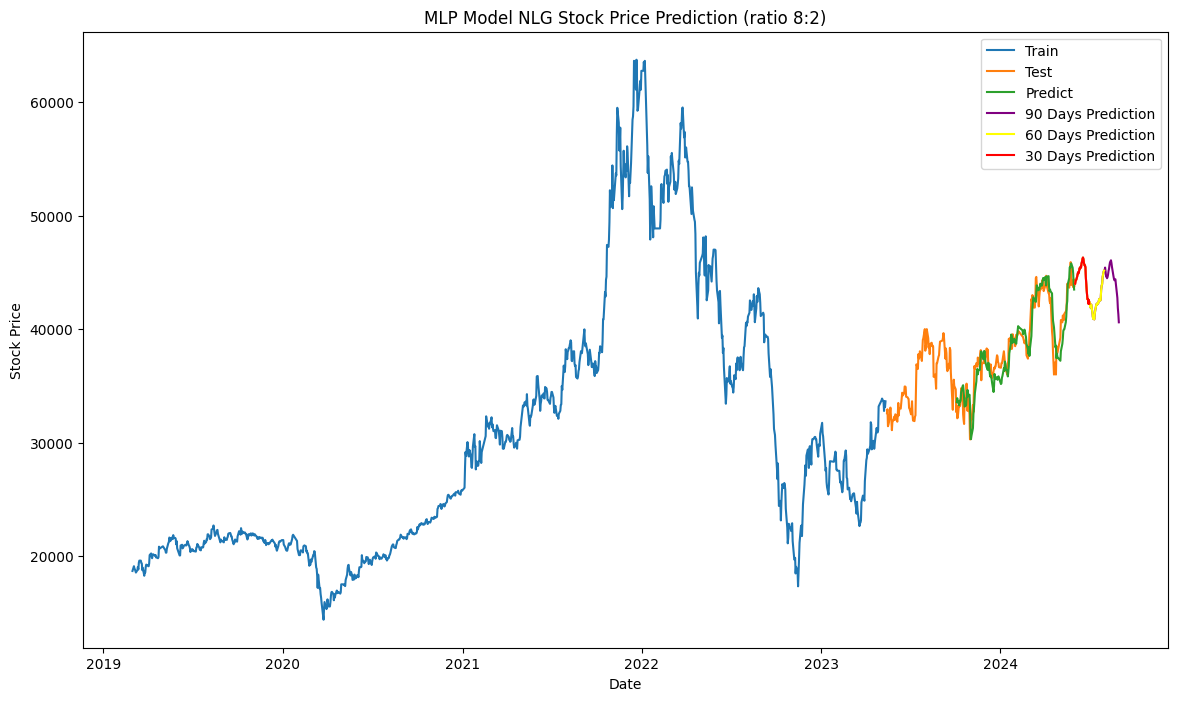

In [ ]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model NLG Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

## Ratio 7:3

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [ ]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(128, input_dim=time_step, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
13/13 [==============================] - 1s 15ms/step - loss: 0.0238 - val_loss: 0.0026
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 3/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 5/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0052
Epoch 8/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 9/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 10/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 11

In [ ]:
# 9. Dự báo dữ liệu test
y_pred = model.predict(X_test)

In [ ]:
# 10. Chuẩn hóa dữ liệu y_pred, y_test
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 1424.5242256656877
Testing MAPE: 3.0168794498522207
Testing MAE: 1081.7141838203925


In [ ]:
# 12. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

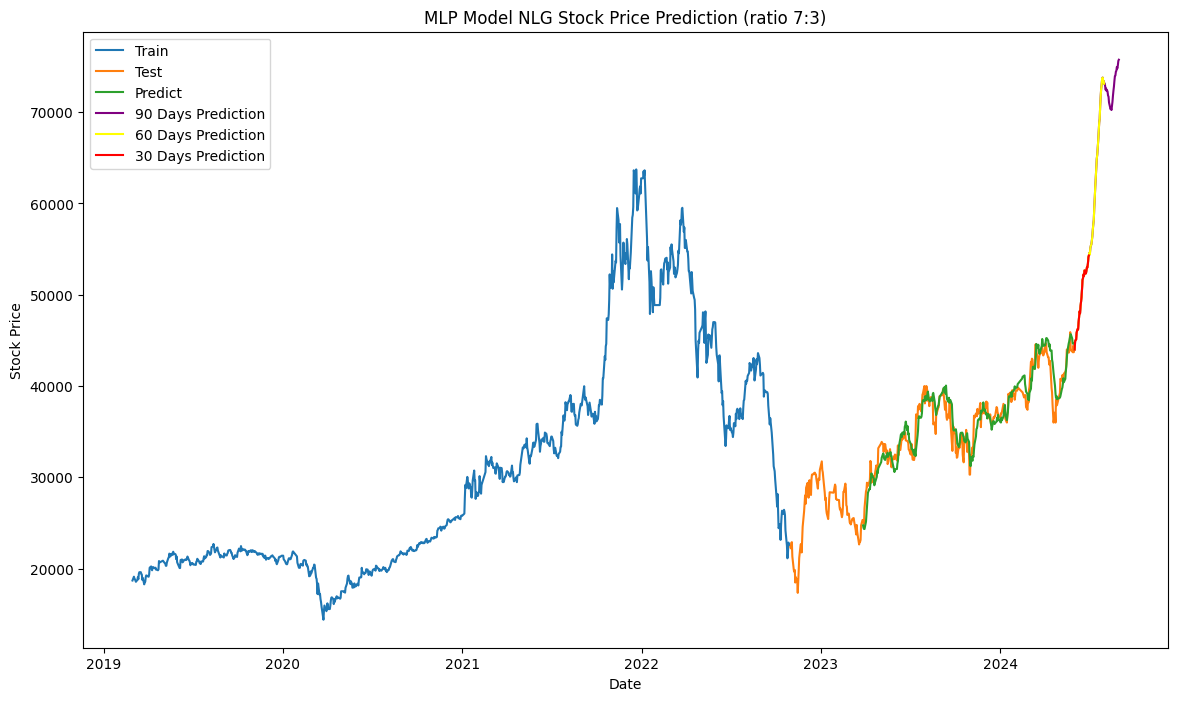

In [ ]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('MLP Model NLG Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()
